In [1]:
# Importing the libraries
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
from gensim.test.utils import datapath
from gensim.models import Word2Vec
import os

# Helpful variables
EXT_DATA_FOLDER = "C:\\Users\\Admin\\Projects\\thesis\\data\\"
EXT_DATA_FOLDER2 = "B:\\Datasets\\"

ANALYSIS_SAMPLES = os.path.join(EXT_DATA_FOLDER, "Credibility_Analysis_Samples\\September_25\\")
dataset_columns = ['Identifier', 'Type', 'Category', 'URL', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5',
 'Cat6', 'Cat7', 'Score', 'First date_time', 'Tweets', 'Likes', 'Retweets',
 'Potential exposure', 'HTML', 'TEXT']
criterias = ["Cat1", "Cat2", "Cat3", "Cat4", "Cat5", "Cat6", "Cat7"]


C:\Users\Admin\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import nltk
from nltk import word_tokenize
from nltk import sent_tokenize
# nltk.download('punkt') #uncomment if running on new machine

In [3]:
def create_dataset(corpus_path, annotated_samples):
    """
    Input: 
    corpus_path: Path for a CSV file containing a list of article URLs and its article text
    annotated_samples: Path of the excel file containing articles and its associated URL along with its labels
    
    Method:
    Retrieves the article text by matching the URLs within the corpus_path and annotated_samples and creates a dataframe 
    containing the URL, article text and the article's corresponding labels.
    
    Output:
    A pandas dataframe
    """
    article_corpus = pd.read_csv(corpus_path)
    annotated_corpus = pd.read_excel((annotated_samples))
    article_corpus.columns = ["URL", "HTML", "TEXT"]
    annotated_articles = annotated_corpus.loc[(annotated_corpus["Cat7"] == 0) | (annotated_corpus["Cat7"] == 1)]
    dataset = pd.merge(annotated_articles, article_corpus, how='left', on='URL')
    return dataset


In [ ]:
corpus_path = os.path.join(EXT_DATA_FOLDER, "url_text.csv")
excel_files = ["sample_third_adam_new.xlsx", "sample_third_amalie_new.xlsx", "sample_third_maryke_new.xlsx"]

df_files = []

for filename in excel_files:
    annotated_path = os.path.join(ANALYSIS_SAMPLES, filename)
    data = create_dataset(corpus_path, annotated_path)
    df_files.append(data)
    
dataset = pd.concat(df_files)

print(dataset.columns.values)
print(dataset.shape)

#Save dataset locally
writer = pd.ExcelWriter("multi_dataset.xlsx")
dataset.to_excel(writer, "Sheet1")
writer.save()

In [7]:
#pre-processing
from collections import defaultdict

labelled_articles = pd.read_excel("dataset3.xlsx")
labelled_articles = labelled_articles.dropna(subset=['TEXT'])
print(labelled_articles.shape)
art_text_sent = np.array([sent_tokenize(article.split("TITLE: ")[1].replace("TEXT: ","").strip(" ")) for article in labelled_articles["TEXT"]])
art_text_word = np.array([word_tokenize(article.split("TITLE: ")[1].replace("TEXT: ","").strip(" ")) for article in labelled_articles["TEXT"]])
art_text_sent_word = np.array([[word_tokenize(sent) for sent in article] for article in art_text_sent])
labels = [labelled_articles["Cat1"], labelled_articles["Cat2"], labelled_articles["Cat3"], labelled_articles["Cat4"], labelled_articles["Cat5"], labelled_articles["Cat6"], labelled_articles["Cat7"]]
labels = np.array(labels).transpose()
multi_labels = np.array([[int(x) for x in row] for row in labels])

(208, 19)


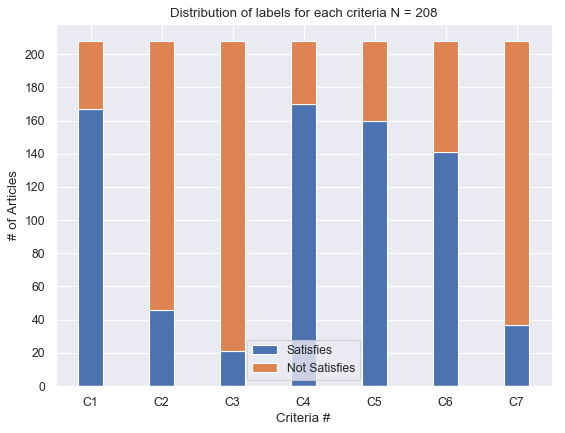

[167, 46, 21, 170, 160, 141, 37]
[41, 162, 187, 38, 48, 67, 171]


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

N = 7
num_articles = len(labelled_articles)
satisfy_count = [len(labelled_articles.loc[(labelled_articles[criteria] == 1)]) for criteria in criterias]
not_satisfy_count = [len(labelled_articles.loc[(labelled_articles[criteria] == 0)]) for criteria in criterias]

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.bar(ind, satisfy_count, width)
p2 = plt.bar(ind, not_satisfy_count, width,
             bottom=satisfy_count)
plt.ylabel('# of Articles')
plt.xlabel('Criteria #')
plt.title('Distribution of labels for each criteria N = ' + str(num_articles))
plt.xticks(ind, ('C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'))
plt.yticks(np.arange(0, num_articles, int(num_articles/10)))
plt.legend((p1[0], p2[0]), ('Satisfies', 'Not Satisfies'))


plt.show()
print(satisfy_count)
print(not_satisfy_count)

[17, 13, 27, 97, 30, 11, 13]


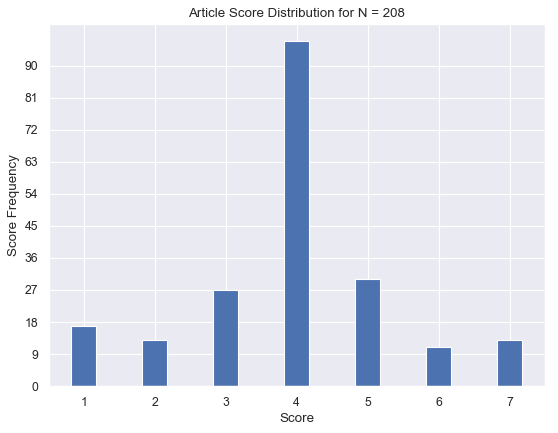

In [25]:
scores = [0, 0, 0, 0 ,0 ,0 ,0]
for article in multi_labels:
    scores[np.sum(article)-1] = scores[np.sum(article)-1] + 1
    
print(scores)

N = 7
maximum = np.amax(scores)

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.bar(ind, scores, width)
plt.ylabel('Score Frequency')
plt.xlabel('Score')
plt.title('Article Score Distribution for N = ' + str(num_articles))
plt.xticks(ind, ('1', '2', '3', '4', '5', '6', '7'))
plt.yticks(np.arange(0, maximum, int(maximum/10)))
plt.show()

In [69]:
print(labelled_articles.columns.values)
scores = labelled_articles.loc[:, 'Cat1':'Cat7'].astype(float)
scores.columns = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
coocc = np.array(scores.T.dot(scores).values.tolist())
print(scores.head())
print(scores.corr())

['Identifier' 'Type' 'Category' 'URL' 'Cat1' 'Cat2' 'Cat3' 'Cat4' 'Cat5'
 'Cat6' 'Cat7' 'Score' 'First date_time' 'Tweets' 'Likes' 'Retweets'
 'Potential exposure' 'HTML' 'TEXT']
    C1   C2   C3   C4   C5   C6   C7
1  1.0  1.0  0.0  1.0  0.0  0.0  1.0
2  0.0  0.0  0.0  1.0  1.0  1.0  0.0
3  1.0  0.0  1.0  1.0  0.0  1.0  0.0
4  1.0  0.0  0.0  1.0  1.0  1.0  0.0
5  1.0  0.0  1.0  1.0  1.0  1.0  1.0
          C1        C2        C3        C4        C5        C6        C7
C1  1.000000  0.205793  0.085818  0.516338  0.388331  0.098102  0.167278
C2  0.205793  1.000000  0.321279  0.132021  0.071909 -0.153270  0.236802
C3  0.085818  0.321279  1.000000  0.117140  0.107798  0.026105  0.094491
C4  0.516338  0.132021  0.117140  1.000000  0.538358  0.339733  0.219923
C5  0.388331  0.071909  0.107798  0.538358  1.000000  0.330602 -0.073450
C6  0.098102 -0.153270  0.026105  0.339733  0.330602  1.000000 -0.217431
C7  0.167278  0.236802  0.094491  0.219923 -0.073450 -0.217431  1.000000


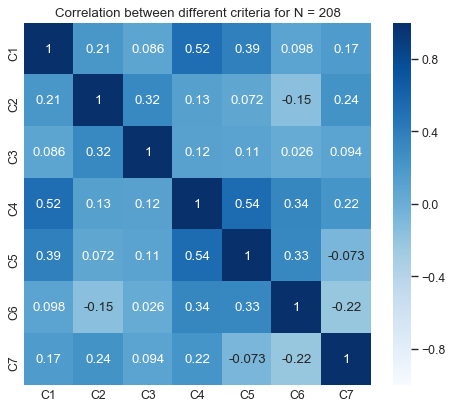

In [79]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
uniform_data = np.random.rand(10, 12)
plt.figure(figsize = (7,6), dpi=80)
ax = sns.heatmap(scores.corr(), annot=True, vmin=-1, vmax=1, cmap="Blues")
ax.tick_params(length=0)
ax.set_title("Correlation between different criteria for N = " + str(len(labelled_articles)))
plt.show()